# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — ``

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Устанавливаем библиотеку phik
!pip install phik

In [2]:
# Импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [3]:
# Загружаем датасет из базы данных и создаем датафрейм df
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': '', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

query = '''
SELECT
  p.user_id,
  p.device_type_canonical,
  p.order_id,
  p.created_dt_msk order_dt,
  p.created_ts_msk order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  EXTRACT(DAY FROM p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY user_id ORDER BY p.created_dt_msk)) days_since_prev,
  p.event_id,
  e.event_name_code event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p 
JOIN afisha.events e ON p.event_id = e.event_id 
JOIN afisha.city c ON e.city_id = c.city_id 
JOIN afisha.regions r ON c.region_id = r.region_id
WHERE device_type_canonical IN ('mobile', 'desktop')
AND event_type_main != 'фильм'
'''

df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [4]:
#выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [5]:
#выводим первые строки датафрейма
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


Датафрейм содержит 15 столбцов и 290611 строк, в которых представлена информация о покупках на сервисе Яндекс Афиша.

- наименования всех строк соответствуют формату snake_case
- типы данных в столбцах
    - `datetime64[ns]` - 2 столбца order_dt и order_ts. Тип datetime64 соответствует данным в этих столбцах.
    - `float64` - 2 столбца: revenue - данные представленым дробными числами, days_since_prev - данные в этом столбце это целочисленные значения, но присутствуют пропуски. Тип float64 корректен для этих столбцов.
    - `int64` - 3 столбца: order_id, tickets_count, event_id - тип int соответствует данным. Можно оптимизировать и понизить разрядность для столбца tickets_count
    - `object` - 8 столбцов: user_id, device_type_canonical, currency_code, event_name, event_type_main, service_name, region_name, city_name. Данные в столбцах - текстовые, соответсвуют типу object.
- пропуски присутствуют только в столбце `days_since_prev`. Также проверим столбцы с категориальными данными проверим на наличие значений-индикаторов, обозначающих отсутствие данных.

Первое знакомство с данными показывает, что данные хорошего качества, пропуски практически отсутствуют, данные в столбцах соответствуют описанию и выглядят корректными.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [6]:
#загружаем датасет о курсе казахстанского тенге по отношению к российскому рублю
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [7]:
#выводим первые значения в датафрейме
df_tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [9]:
#скорректируем тип в столбце data
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

In [10]:
#напишем функцю для приведения выручки к единой валюте
def from_kzt_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    else:
        curs = df_tenge[df_tenge['data'] == row['order_dt']]['curs'].item()
        return round(row['revenue'] / 100 * curs, 2)

In [11]:
#создаем столбец revenue_rub
df['revenue_rub'] = df.apply(from_kzt_to_rub, axis=1)

In [12]:
#проверяем работу функции
df[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.50
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.73
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.15
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.70
460,01370a0e9c1a7d5,desktop,5227657,2024-06-04,2024-06-04 13:28:17,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.30


Привели значение выручки к единой валюте и сохранили данные в столбце `revenue_rub`.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [13]:
#выводим количество пропусков в столбцах
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [14]:
#выводим % пропусков в столбце days_since_prev
df['days_since_prev'].isna().mean() * 100

7.547202273829965

Пропуски присутствуют только в столбце `days_since_prev`. Количество пропусков - 21933 (7,54%)

Оптимизируем размерность в столбце `tickets_count`

In [15]:
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

In [16]:
#проверим оптимизацию типа данные столбца tickets_count
df['tickets_count'].dtype

dtype('int8')

Нормализуем данные в столбцах service_name, region_name, city_name и приведем значения к нижнему регистру

In [17]:
for col in ('service_name', 'region_name', 'city_name'):
    df[col] = df[col].str.lower()

Проверим уникальные значения в столбце `event_type_main`

In [18]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

Данные в столбце `event_type_main` выглядят корректно. Категорию `другое` вероятно можно классифицировать как пропуск. Фильтровать все данные и убирать данную категорию не будем.

Проверим дубликаты в датафрейме

In [19]:
#выводим количество полных дубликатов
df.duplicated().sum()

0

In [20]:
#выводим количество дубликатов по полям user_id, device_type_canonical, order_ts, revenue_rub
df.duplicated(subset=['user_id', 'device_type_canonical', 'order_ts', 'revenue_rub']).sum()

44

In [21]:
#выводим информацию о дубликатах
df[df.duplicated(subset=['user_id', 'device_type_canonical', 'order_ts', 'revenue_rub'], keep=False)].sort_values(by=['user_id', 'revenue'])

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
11758,06eb7897f65b433,mobile,1123867,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,билеты в руки,светополянский округ,глиноград,69.82
11761,06eb7897f65b433,mobile,1123983,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,билеты в руки,светополянский округ,глиноград,69.82
26876,0dc525d7bacbb0d,desktop,1930705,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,0.0,393430,b33d7a0b-a715-47e3-803e-02482884a73e,концерты,лови билет!,каменевский регион,глиногорск,1556.05
26877,0dc525d7bacbb0d,desktop,1930763,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,0.0,393430,b33d7a0b-a715-47e3-803e-02482884a73e,концерты,лови билет!,каменевский регион,глиногорск,1556.05
53681,206ea45ec11d478,mobile,1935113,2024-10-29,2024-10-29 16:46:54,rub,601.69,2,0.0,442183,dcf6f06f-8499-41d7-8bc2-a0e3d7afe313,концерты,билеты в руки,каменевский регион,глиногорск,601.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285379,fd4d47438ebb946,desktop,8548099,2024-06-19,2024-06-19 15:40:56,rub,989.57,3,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,билеты без проблем,каменевский регион,глиногорск,989.57
285385,fd4d47438ebb946,desktop,8547809,2024-06-19,2024-06-19 15:40:56,rub,989.57,3,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,билеты без проблем,каменевский регион,глиногорск,989.57
285381,fd4d47438ebb946,desktop,8547983,2024-06-19,2024-06-19 15:40:56,rub,1319.43,4,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,билеты без проблем,каменевский регион,глиногорск,1319.43
285382,fd4d47438ebb946,desktop,8548012,2024-06-19,2024-06-19 15:40:56,rub,1319.43,4,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,билеты без проблем,каменевский регион,глиногорск,1319.43


Видим, что в дубликатах отличается только поле `order_id`. Вероятно произошла техническая ошибка и в системе задублировались одинаковые заказы. Удалим дубликаты.

In [22]:
#сохраняем количество строк до удаления дубликатов
df_initial_shape = df.shape[0]

#удаляем дубликаты
df = df.drop_duplicates(subset=['user_id', 'device_type_canonical', 'order_ts', 'revenue_rub'])

In [23]:
#выводим количество удаленных дубликатах
df_initial_shape - df.shape[0]

44

In [24]:
#выводим количество удаленных дубликатах в относительных значениях
round((df_initial_shape - df.shape[0]) / df_initial_shape * 100, 2)

0.02

Всего было удалено 44 дубликата (0,02% от всех данных)

Проверим статистические показатели в столбцах `tickets_count`, `revenue_rub`

In [25]:
df[['tickets_count', 'revenue_rub']].describe()

,tickets_count,revenue_rub
count,290567.000000,290567.000000
mean,2.754308,555.593629
std,1.170603,875.532373
min,1.000000,-90.760000
25%,2.000000,113.970000
50%,3.000000,351.140000
75%,4.000000,802.050000
max,57.000000,81174.540000


Построим диаграммы размаха по данным из столбцов `tickets_count`, `revenue_rub`

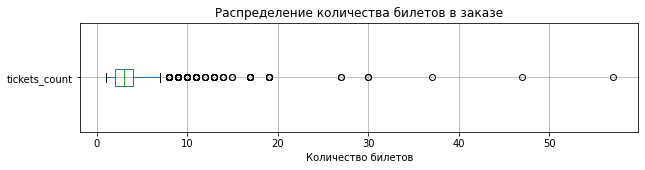

In [26]:
plt.figure(figsize=(10, 2))
df.boxplot(column='tickets_count', vert=False)

plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.show()

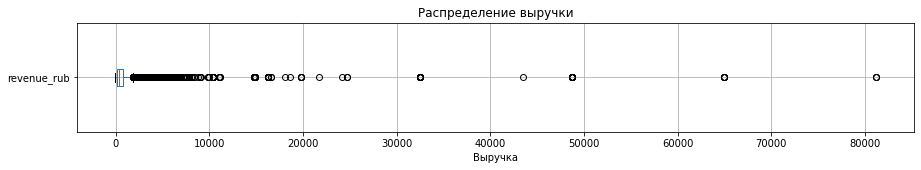

In [27]:
plt.figure(figsize=(15, 2))
df.boxplot(column='revenue_rub', vert=False)

plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.show()

Распределение количества билетов и выручки ассиметричное, скошено вправо. Присутствует большое количество выбросов: для количества билетов в заказе выбросами считаются значения больше 7, для выручки - выбросы это значения больше примерно 2000. Также присутствуют единичиные выбросы с очень большим количеством билетов и высоким значением выручки. Для исключения выбросов отфильтруем данные по 99 перцентилю. В столбце с выручкой также присутствуют отрицательные значения, которые являются некорректными. 

In [28]:
#фильтруем датафрейм и убираем строки со значением выручки меньше 0
df = df[df['revenue_rub'] >= 0]

In [29]:
#фильтруем значения в столбце revenue_rub по 99 перцентилю
df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)]

In [30]:
#посчитаем общее количество отфильтрованных данных
df_initial_shape - df.shape[0]

3250

In [31]:
#посчитаем количество отфильтрованные данных в %
round((df_initial_shape - df.shape[0]) / df_initial_shape * 100, 2)

1.12

В ходе предобработки:
- привели значения выручки к единой валюте и создали столбец `revenue_rub`
- проверили пропуски в датафрейме, они присутствуют только в столбце `days_since_prev` и являются корректными
- оптимизировали тип данных с столбце `tickets_count`
- удалили 44 дубликата
- отфильтровали данные по 99 перцентилю в столбце `revenue_rub`

Всего по результатам предобработки было отфильтровано 3250 строк (1,12 % от всех данных)

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [32]:
#сортируем данные по времени совершения заказа
df = df.sort_values(by='order_ts')

In [33]:
#рассчитаем агрегированные признаки по каждому пользователю
df_profile = df.groupby('user_id').agg({
    'order_dt': ['min', 'max'], 
    'device_type_canonical': 'first', 
    'region_name': 'first',
    'service_name': 'first',
    'event_type_main': 'first',
    'order_id': 'count',
    'revenue_rub': 'mean',
    'tickets_count': 'mean',
    'days_since_prev': 'mean'
})

#скорректируем названия столбцов
df_profile.columns = ['order_dt_first', 
                      'order_dt_last', 
                      'device_type_canonical', 
                      'region_name', 
                      'service_name', 
                      'event_type_main', 
                      'order_count', 
                      'revenue_rub_mean', 
                      'tickets_count_mean', 
                      'days_since_prev_mean']

In [34]:
#добавляем столбцы is_two и is_five
df_profile['is_two'] = df_profile.apply(lambda x: x['order_count'] >= 2, axis=1)
df_profile['is_five'] = df_profile.apply(lambda x: x['order_count'] >= 5, axis=1)

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [35]:
#рассчитаем и выведем данные о пользователях из датафрейма df_profile
print(f'''Общее число пользователей: {df_profile.shape[0]}
Средняя выручка с одного заказа: {round(df_profile['revenue_rub_mean'].mean(), 2)}
Доля пользователей, совершивших 2 и более заказа: {round(df_profile['is_two'].mean(), 4)}
Доля пользователей, совершивших 5 и более заказов: {round(df_profile['is_five'].mean(), 4)}''')

Общее число пользователей: 21838
Средняя выручка с одного заказа: 545.03
Доля пользователей, совершивших 2 и более заказа: 0.617
Доля пользователей, совершивших 5 и более заказов: 0.2899


In [36]:
#проверим статистические показатели столбцов order_count, ticket_count_mean, days_since_prev_mean
df_profile[['order_count', 'tickets_count_mean', 'days_since_prev_mean']].describe()

,order_count,tickets_count_mean,days_since_prev_mean
count,21838.000000,21838.000000,13511.000000
mean,13.158760,2.744062,15.847805
std,121.562439,0.913069,22.304353
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.080000,20.414286
max,10168.000000,11.000000,148.000000


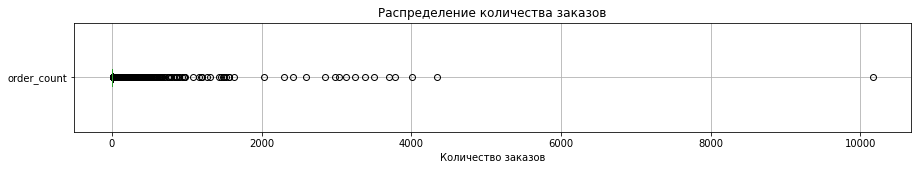

In [37]:
plt.figure(figsize=(15, 2))
df_profile.boxplot(column='order_count', vert=False)

plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.show()

В полях `tickets_count_mean` и `days_since_prev_mean` данные выглядят корректно.

В столбце `order_count` распределение значений неваравномерное и скошено вправо, присутствует большое количество выбросов.  Можно предположить, что пользователи с большим количеством заказов это организации, оформляющие билеты для своих работников, или посредники, оформляющие билеты не в своих интересах. При создании модели для прогнозирования возврата пользователей выбросы в поле `order_count` могут исказить результат и модель будет работать некорректно. Отфильтруем данные в столбце `order_count` по 95 перцентилю для получения более достоверной выборки пользователей.

In [38]:
#сохраняем количество строк до фильтрации
df_profile_initial_shape = df_profile.shape[0]

#фильтруем по данные в столбце order_count по 95 перцентилю
df_profile = df_profile[df_profile['order_count'] <= df_profile['order_count'].quantile(0.95)]

In [39]:
#выводим данные о пользователях из датафрейма df_profile после фильтрации
print(f'''Общее число пользователей: {df_profile.shape[0]}
Средняя выручка с одного заказа: {round(df_profile['revenue_rub_mean'].mean(), 2)}
Доля пользователей, совершивших 2 и более заказа: {round(df_profile['is_two'].mean(), 4)}
Доля пользователей, совершивших 5 и более заказов: {round(df_profile['is_five'].mean(), 4)}''')

Общее число пользователей: 20747
Средняя выручка с одного заказа: 547.3
Доля пользователей, совершивших 2 и более заказа: 0.5969
Доля пользователей, совершивших 5 и более заказов: 0.2525


In [40]:
#проверим статистические показатели столбцов order_count, ticket_count_mean, days_since_prev_mean
df_profile[['order_count', 'tickets_count_mean', 'days_since_prev_mean']].describe()

,order_count,tickets_count_mean,days_since_prev_mean
count,20747.000000,20747.000000,12420.000000
mean,4.048682,2.744538,17.050250
std,5.113080,0.934506,22.872212
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,9.466667
75%,5.000000,3.153846,22.000000
max,31.000000,11.000000,148.000000


In [41]:
#рассчитаем количество отфильтрованных записей
print(f'''Количество отфильтрованных записей в абсолютном значении: {df_profile_initial_shape - df_profile.shape[0]}
Количество отфильтрованных записей в %: {round((df_profile_initial_shape - df_profile.shape[0]) / df_profile_initial_shape * 100, 2)}''')

Количество отфильтрованных записей в абсолютном значении: 1091
Количество отфильтрованных записей в %: 5.0


Подготовили данные для исследовательского анализа:
- в выборке присутствует 20747 пользователей, что достаточно для анализа и подготовки данных и дальнейшего создания модели;
- в столбце `order_count` присутствовали аномальные значения, провели фильтрация по 95 перцентилю;
- всего было отфильтровано 1091 значение.

Портрет пользователя сервиса Яндекс Афиша за отчетный период:
- чаще всего пользователь делает 2 заказа
- в среднем в заказе 3 билета
- если пользователь совершал заказ неоднократно, то в среднем интервал между заказами составил 17 дней
- 60% всех пользователей совершили 2 и более заказа
- 25% всех пользователей совершили 5 и более заказов
- в среднем стоимость заказа составила 547 руб.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


- Проверим пользователей по типу их первого мероприятия

In [42]:
#проверяем распределение пользователей по типу их первого мероприятия без учета записей, где указано "другое"
group_1 = df_profile[df_profile['event_type_main'] != 'другое']['event_type_main']
group_1.value_counts()

концерты    9191
театр       4070
стендап     1069
спорт        765
выставки     401
ёлки          94
Name: event_type_main, dtype: int64

In [43]:
#распределение пользователей по типу их первого мероприятия в относительных значениях
group_1.value_counts(normalize=True)

концерты    0.589545
театр       0.261065
стендап     0.068570
спорт       0.049070
выставки    0.025722
ёлки        0.006030
Name: event_type_main, dtype: float64

Значения распределены неравномерно, первое мероприятие у пользователей чаще всего это концерт (9191 пользователь - 59%), далее идет театр (4070 пользователей - 26%).

- Далее проверим пользователей по типу устройства, с которого совершена первая покупка

In [44]:
#распределение пользователей по типу их устройства
group_2 = df_profile['device_type_canonical']
group_2.value_counts()

mobile     17208
desktop     3539
Name: device_type_canonical, dtype: int64

In [45]:
group_2.value_counts(normalize=True)

mobile     0.829421
desktop    0.170579
Name: device_type_canonical, dtype: float64

Пользователи значительно чаще совершали первый заказ с помощью мобильного телефона: всего таких пользователей 17208, что составляет 83% от общего числа

- Проверим распределение пользователей по региону проведения первого заказа

In [46]:
#распределение пользователей по региону проведения первого заказа
group_3 = df_profile['region_name']
group_31 = group_3.value_counts()[:10]
group_31

каменевский регион      6781
североярская область    3599
широковская область     1183
озернинский край         660
малиновоярский округ     516
травяная область         469
шанырский регион         463
светополянский округ     436
речиновская область      421
яблоневская область      399
Name: region_name, dtype: int64

In [47]:
group_32 = group_3.value_counts(normalize=True)[:10]
group_32

каменевский регион      0.326842
североярская область    0.173471
широковская область     0.057020
озернинский край        0.031812
малиновоярский округ    0.024871
травяная область        0.022606
шанырский регион        0.022316
светополянский округ    0.021015
речиновская область     0.020292
яблоневская область     0.019232
Name: region_name, dtype: float64

Среди регионов, где пользователи совершили первый заказ лидируют `каменевский регион` и `североярская область`

- Проверяем распределение пользователей по билетному оператору, продавшему билеты на первый заказ

In [48]:
#распределение пользователей по билетному оператору
group_4 = df_profile['service_name']
group_41 = group_4.value_counts()[:10]
group_41

билеты без проблем    4958
мой билет             2853
лови билет!           2707
билеты в руки         2423
облачко               2108
весь в билетах        1234
лучшие билеты         1130
прачечная              550
край билетов           438
дом культуры           340
Name: service_name, dtype: int64

In [49]:
group_42 = group_4.value_counts(normalize=True)[:10]
group_42

билеты без проблем    0.238974
мой билет             0.137514
лови билет!           0.130477
билеты в руки         0.116788
облачко               0.101605
весь в билетах        0.059478
лучшие билеты         0.054466
прачечная             0.026510
край билетов          0.021111
дом культуры          0.016388
Name: service_name, dtype: float64

Среди билетных операторов выделяется лидер - `билеты без проблем` c 4958 пользователями (24%), далее можно выделить группу из 4-х операторов `мой билет` `лови билет!` `билеты в руки` `облачко` с 10-14% пользователей.

- В каждой рассмотренной группе данные распределены неравномерно и присутствует явно выраженный лидер. Среди типов мероприятий - `концерт`, среди устройств - `мобильные телефоны`, из регионов выделяется `каменевский район`, а среди операторов - `билеты без проблем`.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [50]:
#рассчитываем долю пользователей, совершивших 2 и более заказа, с группировкой по типу первого мероприятия
group_1 = df_profile[df_profile['event_type_main'] != 'другое'].groupby('event_type_main')['is_two'].value_counts(normalize=True).unstack().sort_values(by=1, ascending=False)
group_1

is_two,False,True
event_type_main,,
выставки,0.369077,0.630923
театр,0.381327,0.618673
концерты,0.397345,0.602655
стендап,0.405987,0.594013
ёлки,0.446809,0.553191
спорт,0.458824,0.541176


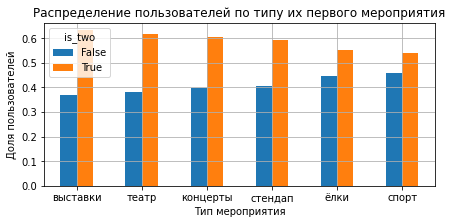

In [51]:
#визуализируем и построим столбчатую диаграмму
group_1.plot(
    kind='bar',
    title=f'Распределение пользователей по типу их первого мероприятия',
    ylabel='Доля пользователей',
    xlabel='Тип мероприятия',
    legend=True,
    rot=0,
    figsize=(7, 3)
)
plt.grid()

# Выводим график
plt.show()

Чаще всего пользователи совершали повторные заказы, если первый заказ был в категории выставки. Ниже всего доля тех пользователей с повторными заказами, у кого первый заказ был в категории елки и спорт.

In [52]:
#рассчитываем долю пользователей, совершивших 2 и более заказа, с группировкой по типу устройства
group_2 = df_profile.groupby('device_type_canonical')['is_two'].value_counts(normalize=True).unstack().sort_values(by=1, ascending=False)
group_2

is_two,False,True
device_type_canonical,,
desktop,0.379768,0.620232
mobile,0.407892,0.592108


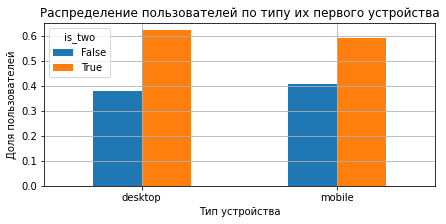

In [53]:
#визуализируем и построим столбчатую диаграмму
group_2.plot(
    kind='bar',
    title=f'Распределение пользователей по типу их первого устройства',
    ylabel='Доля пользователей',
    xlabel='Тип устройства',
    legend=True,
    rot=0,
    figsize=(7, 3)
)
plt.grid()

# Выводим график
plt.show()

Значительной разницы в доле повторных пользователей при группировке по типу устройства, с которого был совершен первый заказ нет. Немного больше доля среди пользователей, кто совершил первый заказ с компьютера, нежели с мобильльного телефона (62% против 59% соответственно)

In [54]:
#рассчитываем долю пользователей, совершивших 2 и более заказа, с группировкой по району
group_3 = df_profile[df_profile['region_name'].isin(group_31.index)].groupby('region_name')['is_two'].value_counts(normalize=True).unstack().sort_values(by=1, ascending=False)
group_3

is_two,False,True
region_name,,
шанырский регион,0.354212,0.645788
светополянский округ,0.360092,0.639908
широковская область,0.367709,0.632291
североярская область,0.378716,0.621284
речиновская область,0.382423,0.617577
каменевский регион,0.393010,0.606990
травяная область,0.400853,0.599147
яблоневская область,0.418546,0.581454
малиновоярский округ,0.449612,0.550388


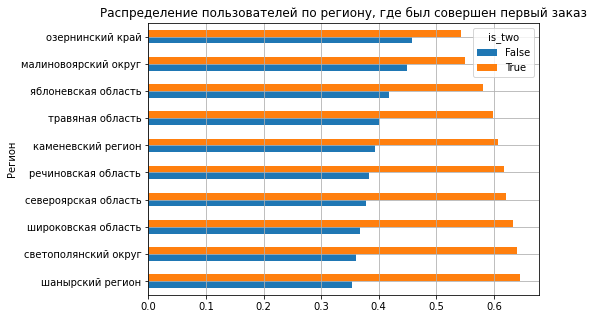

In [55]:
#визуализируем и построим столбчатую диаграмму
group_3.plot(
    kind='barh',
    title=f'Распределение пользователей по региону, где был совершен первый заказ',
    ylabel='Доля пользователей',
    xlabel='Регион',
    legend=True,
    rot=0,
    figsize=(7, 5)
)
plt.grid()

# Выводим график
plt.show()

Среди топ-10 регионов в 8 регионах приблизительно схожая картина по доле повторных пользователей (от 58 до 64%) и близка к среднему по всем регионам (60%). Явного лидера по доле пользователей, совершивших повторные заказы, нет. В 2-х регионах (озернинский и малиновоярский) из топ-10 доля пользователей с повторными заказами немного ниже, чем в остальных (54% и 55% соответственно)

In [56]:
#рассчитываем долю пользователей, совершивших 2 и более заказа, с группировкой по району
group_4 = df_profile[df_profile['service_name'].isin(group_41.index)].groupby('service_name')['is_two'].value_counts(normalize=True).unstack().sort_values(by=1, ascending=False)
group_4

is_two,False,True
service_name,,
край билетов,0.360731,0.639269
дом культуры,0.370588,0.629412
весь в билетах,0.386548,0.613452
билеты в руки,0.392901,0.607099
прачечная,0.396364,0.603636
облачко,0.400380,0.599620
лучшие билеты,0.404425,0.595575
лови билет!,0.405615,0.594385
мой билет,0.407291,0.592709


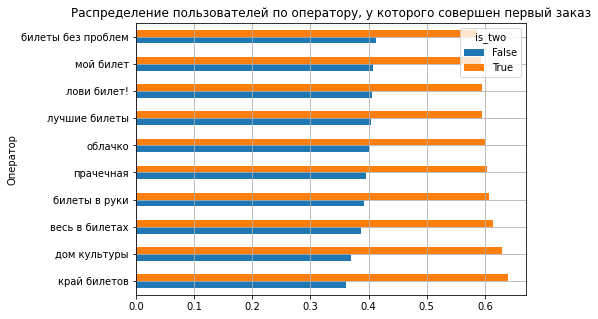

In [57]:
#визуализируем и построим столбчатую диаграмму
group_4.plot(
    kind='barh',
    title=f'Распределение пользователей по оператору, у которого совершен первый заказ',
    ylabel='Доля пользователей',
    xlabel='Оператор',
    legend=True,
    rot=0,
    figsize=(7, 5)
)
plt.grid()

# Выводим график
plt.show()

Среди топ-10 операторов приблизительно одинаковая доля повторных пользователей (от 58 до 64%) и близка к среднему по всем регионам (60%). Явного лидера с большим отрывом по доле пользователей с повторными заказами нет.

По итогам рассмотрения пользователей по доле повторных заказов небольшая небольшая разница присутствует при разбивке по регионам первого заказа и категории первого заказа. Но явно выделить регион или тип мероприятия первого заказа, которые влияют на повторные покупки нельзя.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [58]:
#делаем выборку для проверки 1 гипотезы
group = df_profile[(df_profile['event_type_main'] == 'спорт') | (df_profile['event_type_main'] == 'концерты')].groupby('event_type_main')['is_two'].value_counts(normalize=True).unstack().sort_values(by=1, ascending=False)
group

is_two,False,True
event_type_main,,
концерты,0.397345,0.602655
спорт,0.458824,0.541176


Гипотеза 1 не подтвердилась. Пользователи, которые совершили первый заказ на спортивные мероприятия, реже совершают повторный заказ (54% пользователей), чем пользователи, оформивные первый заказ на концерты (60% пользователей)

Для проверки гипотезы 2 разобьем топ-20 регионов по количеству пользователей на 2 части и сравним долю повторных заказов в этих группах. Остальные регионы рассматривать не будет ввиду меньшего количества пользователей и возможной высокой вариативности данных.

In [59]:
group_1 = df_profile['region_name'].value_counts()[:10]
group_2 = df_profile['region_name'].value_counts()[10:20]
top_10_share = df_profile[df_profile['region_name'].isin(group_1.index)]['is_two'].mean()
top_11_20_share = df_profile[df_profile['region_name'].isin(group_2.index)]['is_two'].mean()
print(f'''Доля пользователей, совершивших повторный заказ:
    в топ-10 регионах по количеству пользователей: {round(top_10_share, 2)}
    в регионах с 11 по 20 место по количеству пользователей: {round(top_11_20_share,2 )}''')

Доля пользователей, совершивших повторный заказ:
    в топ-10 регионах по количеству пользователей: 0.61
    в регионах с 11 по 20 место по количеству пользователей: 0.57


Гипотеза 2 подтвердилась. Среди топ-10 регионов и регионов с 11 по 20 места в среднем доля пользователей, совершивших повторный заказ, немного выше (0.61 и 0.57 соответственно)

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


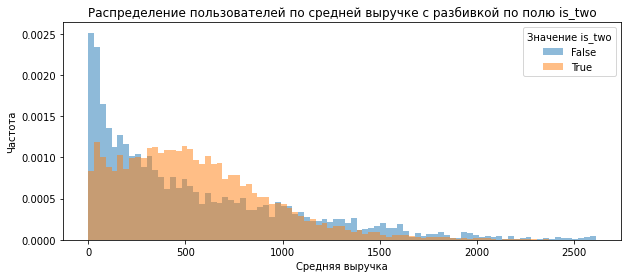

In [60]:
#строим гистограмму распределения значений средней выручки
plt.figure(figsize=(10, 4))

#находим минимальное и максимальное значение
min_r = round(df_profile['revenue_rub_mean'].min())
max_r = round(df_profile['revenue_rub_mean'].max())

#для каждого значения в поле is_two строим гистограмму
for i in df_profile['is_two'].unique():
    df_profile[df_profile['is_two'] == i]['revenue_rub_mean'].plot(
        kind='hist',
        alpha=0.5,
        density=True,
        bins=range(min_r, max_r + 1, 30),
        label=i,
        legend=True
    )

plt.title('Распределение пользователей по средней выручке с разбивкой по полю is_two')
plt.xlabel('Средняя выручка')
plt.ylabel('Частота')
plt.legend(title='Значение is_two')
plt.show()

По графику видно, что распределение выручки пользователей, совершивших 2 и более заказа сдвинуто вправо по сравнению с распределение пользователей, сделавших 1 заказ. Распределение пользователей, сделавших 1 заказ, сконцентировано в диапазоне средней выручки до 100 руб. Распределение пользователей с 2 и более заказами сконцентрировано в диапазоне до 700 руб. Исходя из полученных данных можно сделать вывод, что с повышением средней выручки пользователи более склонны к повторным заказам.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [61]:
#выделяем 2 группы пользователей (2-4 заказа и более 5 заказов)
group_2_4_orders = df_profile[(df_profile['is_two'] == True) & (df_profile['is_five'] == False)]
group_5_orders = df_profile[df_profile['is_five'] == True]

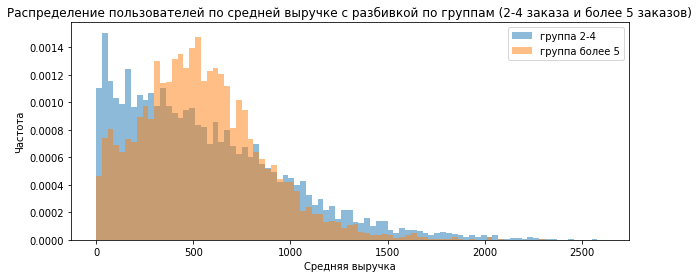

In [62]:
#строим гистограммы распеределения средней выручки по выделенным группам
plt.figure(figsize=(10, 4))

for group in (group_2_4_orders, group_5_orders):
    group['revenue_rub_mean'].plot(
        kind='hist',
        alpha=0.5,
        density=True,
        bins=range(min_r, max_r + 1, 30),
        legend=True,
    )

plt.title('Распределение пользователей по средней выручке с разбивкой по группам (2-4 заказа и более 5 заказов)')
plt.xlabel('Средняя выручка')
plt.ylabel('Частота')
plt.legend(['группа 2-4', 'группа более 5'])
plt.show()

In [63]:
#рассчитаем значение средней выручки по выделенным группам
print(f'''Среднее значение выручки среди пользователей с 2-4 заказами: {round(group_2_4_orders['revenue_rub_mean'].mean(), 2)}
Среднее значение выручки среди пльзователей с 5 и более заказами: {round(group_5_orders['revenue_rub_mean'].mean(), 2)}''')

Среднее значение выручки среди пользователей с 2-4 заказами: 552.26
Среднее значение выручки среди пльзователей с 5 и более заказами: 542.97


Среднее значение выручки для пользователей с 2-4 заказами больше, чем у пользователей с 5 заказами, по графику видим, что распределение для пользователей с 5 и более заказами смещено правее по сравнению с пользователями с 2-4 заказами и сконцертировано в диапазоне 300-700 руб. Для пользователей с 2-4 заказами более характерны заказы до 300 руб., а также чаще встречаются дорогие заказы (более 1000 руб.)

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`tickets_count_mean`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [64]:
#выделяем 4 группы по количеству билетов
group_1_2 = df_profile[df_profile['tickets_count_mean'] <= 2]
group_2_3 = df_profile[(df_profile['tickets_count_mean'] >= 2) & (df_profile['tickets_count_mean'] <= 3)]
group_3_5 = df_profile[(df_profile['tickets_count_mean'] >= 3) & (df_profile['tickets_count_mean'] <= 5)]
group_5 = df_profile[df_profile['tickets_count_mean'] >= 5]

#присвоим наименование каждой группе
group_1_2.name = 'Сегмент от 1 до 2 билетов'
group_2_3.name = 'Сегмент от 2 до 3 билетов'
group_3_5.name = 'Сегмент от 3 до 5 билетов'
group_5.name = 'Сегмент 5 и более билетов'

In [65]:
#рассчитываем общее число пользователей и долю пользователей, совершивших повторные заказы
for group in (group_1_2, group_2_3, group_3_5, group_5):
    print(f'''{group.name}:
    Общее число пользователей: {group.shape[0]}
    Доля пользователей, совершивших повторный заказ: {round(group['is_two'].mean(), 2)}
    ''')

Сегмент от 1 до 2 билетов:
    Общее число пользователей: 6146
    Доля пользователей, совершивших повторный заказ: 0.4
    
Сегмент от 2 до 3 билетов:
    Общее число пользователей: 12906
    Доля пользователей, совершивших повторный заказ: 0.61
    
Сегмент от 3 до 5 билетов:
    Общее число пользователей: 9396
    Доля пользователей, совершивших повторный заказ: 0.52
    
Сегмент 5 и более билетов:
    Общее число пользователей: 661
    Доля пользователей, совершивших повторный заказ: 0.19
    


Пользователи по выделенным группам по среднему количеству билетов в заказе распределены неравномерно. Больше всего пользователей в группах 2-3 билета (12906) и 3-5 билетов (9396). Меньше всего пользователей в группе 5 и более билетов (661). По доле пользователей, совершивших повторный заказ лидирует группа 2-3 билета (0.61) - это значение примерно соответствует среднему значению по датафрейму, далее следует группа 3-5 билетов (доля составляет 0.52). Меньше всего доля пользователей с повторными заказами в сегменте от 5 и более билетов (0.19).

Таким образом резюмируем, что пользователи со средним значением билетов в заказе от 2 до 5 шт. более склонны к повторным заказам, нежели другие.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [66]:
#группируем пользователей по дню недели первой покупки
group = df_profile.groupby(df_profile['order_dt_first'].dt.day_name())['is_two']
group.value_counts().unstack().sort_values(by=1)

is_two,False,True
order_dt_first,,
Sunday,1109,1532
Monday,1080,1733
Thursday,1262,1764
Wednesday,1155,1805
Tuesday,1210,1814
Friday,1310,1853
Saturday,1237,1883


In [67]:
#выводим долю пользователей с повторными заказами с разбивкой по дням недели
round(group.value_counts(normalize=True).unstack(), 2).sort_values(by=1)

is_two,False,True
order_dt_first,,
Sunday,0.42,0.58
Thursday,0.42,0.58
Friday,0.41,0.59
Saturday,0.40,0.60
Tuesday,0.40,0.60
Wednesday,0.39,0.61
Monday,0.38,0.62


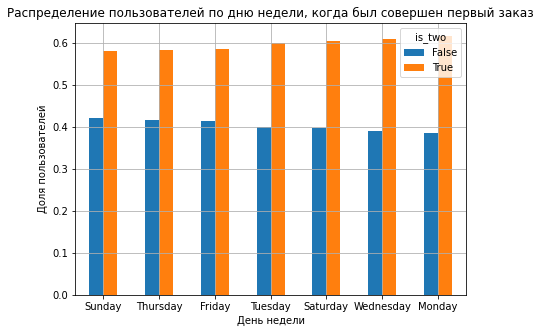

In [68]:
#визуализируем данные и построим столбчатую диаграмму
group.value_counts(normalize=True).unstack().sort_values(by=1).plot(
    kind='bar',
    title=f'Распределение пользователей по дню недели, когда был совершен первый заказ',
    ylabel='Доля пользователей',
    xlabel='День недели',
    legend=True,
    rot=0,
    figsize=(7, 5)
)
plt.grid()

# Выводим график
plt.show()

Пользователи, совершившие свой первый заказ в среду и понедельник, немного чаще (в 62% и 61% случаев) совершают повторные заказы, чем другие пользователи. Но явного влияния дня недели первого заказа на вероятность возврата пользователя не наблюдается.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [69]:
#рассчитаем и выведем данные о среднем интервале между заказами для 2-х групп
print(f'''Среднее время между заказами для двух групп людей:
    - совершивших 2-4 заказа - {round(group_2_4_orders['days_since_prev_mean'].mean())} день
    - совершивших 5 и более заказов - {round(group_5_orders['days_since_prev_mean'].mean())} дней
''')

Среднее время между заказами для двух групп людей:
    - совершивших 2-4 заказа - 21 день
    - совершивших 5 и более заказов - 11 дней



Для группы людей, совершивших 5 и более заказов, средний интервал между заказами составляет 11 дней, для группы людей с 2-4 заказами средний интервал составляет 21 день. Таким образом чем чаще пользователь совершает заказы, чем выше вероятность большего количества заказов.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`order_count`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `orders_count`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `order_count`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [70]:
#рассчитаем матрицу корреляции с использованием phi_k
corr_matrix = df_profile.phik_matrix()
corr_matrix = corr_matrix.loc[corr_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)

interval columns not set, guessing: ['order_count', 'revenue_rub_mean', 'tickets_count_mean', 'days_since_prev_mean']


Убираем признаки is_five, is_two, так как они являются производными столбца order_count и эти признаки будут иметь сильную корреляция с признаком order_count. Также не будем рассматривать признаки: дата первого заказа и дата последнего заказа, так как эти признаки не являются ни интревальными, ни категориальными признаками.

In [71]:
#убираем признаки is_five, is_two, так как они являются производными
corr_matrix = corr_matrix.drop(['is_five', 'is_two', 'order_dt_first', 'order_dt_last'])
corr_matrix

,order_count
days_since_prev_mean,0.489521
tickets_count_mean,0.296819
revenue_rub_mean,0.263478
device_type_canonical,0.050357
service_name,0.037748
event_type_main,0.034079
region_name,0.018837


Наибольшую коррекляцию признак `order_count` имеет с признаками `days_since_prev_mean` `tickets_count_mean` `revenue_rub_mean`.
Значения не близки к нулю, видны связи между признаками, но тем не менее разобьем столбец `order_count` на 3 категории: 1 заказ, 2-4 заказа, 5 и более заказов и построим матрицу корреляции по добавленному столбцу

In [72]:
#дополняем дафафрейм столбцом 'order_count_cat'
df_profile.loc[df_profile['order_count'] == 1, 'order_count_cat'] = 1
df_profile.loc[(df_profile['order_count'] >= 2) & (df_profile['order_count'] <= 4), 'order_count_cat'] = 2
df_profile.loc[df_profile['order_count'] >= 5, 'order_count_cat'] = 3

In [73]:
#вычисляем повторно матрицу корреляции теперь по признаку 'order_count_cat'
corr_matrix = df_profile.phik_matrix()
corr_matrix = corr_matrix.loc[corr_matrix.index != 'order_count_cat'][['order_count_cat']].sort_values(by='order_count_cat', ascending=False)
corr_matrix = corr_matrix.drop(['is_five', 'is_two', 'order_dt_first', 'order_dt_last', 'order_count'])
corr_matrix

interval columns not set, guessing: ['order_count', 'revenue_rub_mean', 'tickets_count_mean', 'days_since_prev_mean', 'order_count_cat']


,order_count_cat
days_since_prev_mean,0.376415
tickets_count_mean,0.358666
revenue_rub_mean,0.297940
region_name,0.105415
service_name,0.072843
event_type_main,0.040580
device_type_canonical,0.015280


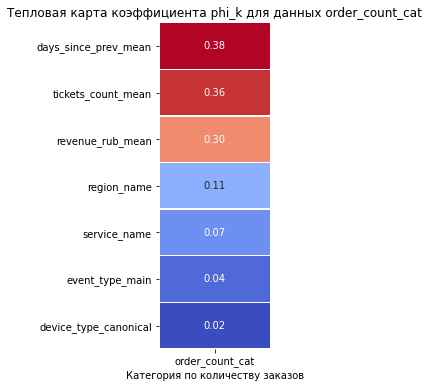

In [74]:
#визуализируем матрицу с помощью тепловой карты
plt.figure(figsize=(2, 6))

sns.heatmap(corr_matrix,
            annot=True, 
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5, 
            cbar=False
           )

plt.title('Тепловая карта коэффициента phi_k для данных order_count_cat')
plt.xlabel('Категория по количеству заказов')

# Выводим график
plt.show()

С учетом введения категории по количеству заказов и проведения повторного рассчета матрицы корреляции наибольшую связь признак `order_count_cat` имеет с признаками `days_since_prev_mean` `tickets_count_mean` `revenue_rub_mean`.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

---

Для проведения исследования был использован датасет от Яндекс Афиши объемом 290611 строк. Целью анализа было выявить какие пользователи с большей вероятностью совершают повторные заказы на платформе.

В ходе предобработки:
- Часть данных о выручке за заказ была представлена в тенге. С помощью датасета с информацией о курсе тенге к рублю создали новые столбец `revenue_rub`, в котором все данные о выручке приведены к единой валюте (рубли).
- Удалили 44 дубликата.
- В поле `revenue_rub` обнаружили выбросы, а также отрицательные значения. Провели фильтрацию по 99 перцентилю и убрали отрицательные значения.
- Всего по результатам предобработки было отфильтровано 3250 строк (1,12 % от всех данных)

На основе полученных данных сформирован датафрейм `df_profile`, описывающий агрегированые харакатеристики каждого пользователя. Также добавлены бинарные признаки `is_two`, `is_five`, описывающие факт совершения пользователем больше 2 и больше 5 заказов:
- Общее число пользователей в датафрейме до обработки - 21838.
- Выявили аномальные значения по полю с общим количеством заказов, провели фильтрацию по 95 перцентилю. Всего было отфильтровано 1091 пользователей. 
- В результате для дальнейшего анализа использовали выборку из 20747 пользователей.
- Описали статистические показатели типичного пользователя сервиса Яндекс Афиша:
    - чаще всего пользователь делает 2 заказа
    - в среднем в заказе 3 билета
    - средний интервал между заказами для пользователей с повторными заказами - 17 дней 
    - 60% всех пользователей совершили 2 и более заказа
    - 25% всех пользователей совершили 5 и более заказов
    - в среднем стоимость заказа составила 547 руб.

Провели анализ полученного датафрейма `df_profile`:
- Явные "точки выхода" среди категорий, характеризующих первый заказ пользователя, отсутствуют.
- При рассмотрении средней выручки с заказа определили, что с повышением средней выручки (более 300 руб.) пользователи более склонны к повторным заказам.
- Пользователи со средним значением билетов в заказе от 2 до 5 шт. чаще делают повторные заказы.
- По времененным характеристикам отметили, что при уменьшении интервала между покупками пользователи склонны к совершению большего числа покупок.
- Рассчитав матрицу корреляции количества заказов с другими признаками выявили, что интервал между заказами, среднее количество билетов в заказе и средняя выручка с заказа имеют наибольшую связь с количеством заказов. 

В качестве рекомендации в первую очередь следует повысить вовлеченность путем предложения персональных условий категории клиентов со средним значением билетов в заказе от 2 до 5 шт. и средней выручкой за заказ более 300 руб. Также необходимо обратить внимание на новых пользователей, совершающих заказы с небольшими интервалами времени, и поддерживать их интерес к платформе.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**